## Import packages

In [1]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import cm
from scipy import io
import time
from scipy.ndimage.filters import gaussian_filter1d

from sca.models import fit_sca, weighted_pca, weighted_rrr
from sca.util import get_sample_weights

ImportError: cannot import name 'fit_sca' from 'sca.models' (/Users/jig289/Dropbox/PD/ssa_update_setup/sca/models.py)

In [ ]:
# %load_ext autoreload
# %autoreload 2

## Load Data

In [2]:
load_folder='/Users/jig289/Dropbox/MATLAB/'
data=io.loadmat(load_folder+'kaufman_trial_py2_good_fewertr') #fewer neurons

In [3]:
move_time_rel=data['move_time_rel'] #time of movement relative to target (target always occurs at 30 bins here)
neural_data=data['neural_data'] #neural data
condition=data['condition'] #the trial condition number (there are 108 conditions)
vels=data['vel'] #velocities for each trial

In [5]:
array_idx=data['array_idx']  ### Contains whether the unit was PMd (1) or M1 (2)
m1_start=np.where(array_idx[0]==2)[0][0]

In [6]:
array_idx

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], dtype=uint8)

In [7]:
m1_start

88

## Preprocess data

In [46]:
#Smooth and collect attributes in lists
sig=5 #5 bins (50 ms) stdev for smoothing
tr_data=[]
tr_lengths=[]
conds=[]
for tr in range(200):#(neural_data.shape[1]):   #just fitting over 200 trials for now (out of a total of 2296)
    tr_data.append(gaussian_filter1d(neural_data[0,tr].astype(float), sig,axis=1)) #neural data
    tr_lengths.append(neural_data[0,tr].shape[1]) #trial lenths
    conds.append(condition[0,tr][0][0]) #trial conditions
    
    
tr_data_concat=np.hstack(tr_data) #concatenate trials to get single matrix
tr_data_concat_norm=tr_data_concat/(np.std(tr_data_concat,axis=1)[:,None]+.05)  #soft normalization of firing rates
data_snm_norm=tr_data_concat_norm-np.mean(tr_data_concat_norm,axis=1)[:,None] #subtract mean of each neuron

## Fit models

#### Choose data and hyperparameters

In [47]:
#Note that model requires (T x N) input rather than (N x T), which is why there are transposes below

fit_data=np.copy(data_snm_norm.T)

In [48]:
R_est=20
sample_weights=get_sample_weights(fit_data)

### Fit PCA for comparison

In [49]:
# U_est_w,V_est_w = weighted_pca(fit_data,R_est,sample_weights)
U_est_w,V_est_w = weighted_pca(fit_data,R_est)

pca_latent = fit_data@U_est_w

### Fit SSA

In [50]:
t1=time.time()

model, latent, y_pred, losses = fit_sca(X=fit_data,R=R_est,sample_weight=sample_weights,orth=False,n_epochs=6000)


print("time",time.time()-t1)

ssa_latent=latent.detach().numpy()

Using lam_sparse=  0.1625634643711845
Using lam_orthog=  18782.850934299935
Using device cpu


100%|██████████| 6000/6000 [06:19<00:00, 15.80it/s]

time 380.65533089637756


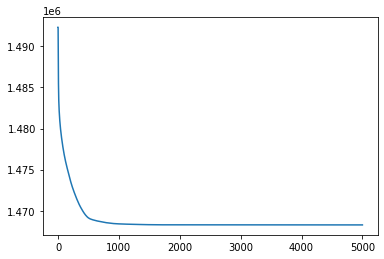

In [89]:
plt.plot(losses)

## Plot latents

### Plot without any reordering

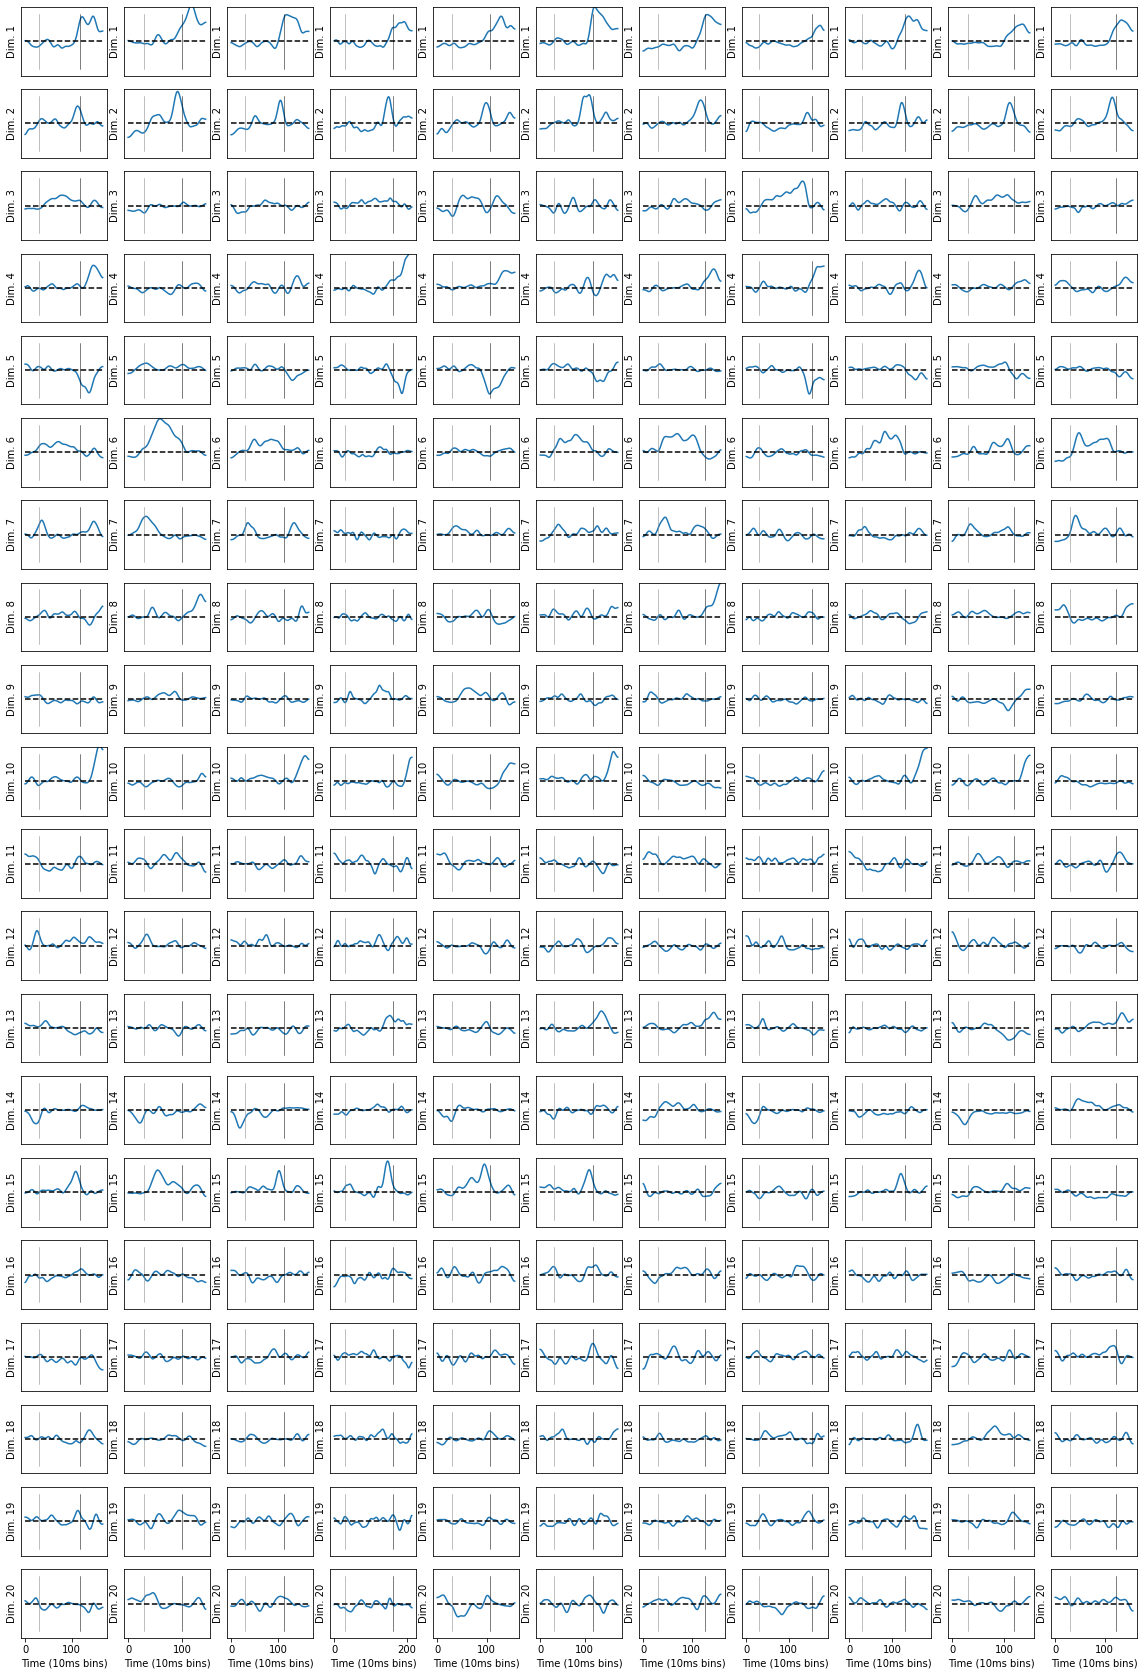

In [85]:
#Get indices of each trial
# T=interp_array.shape[2] #Length of time per condition



tr_lengths_cum=np.hstack([0, np.cumsum(tr_lengths)])

trs=[0,1,2,3,4,5,6,7,8,9,10]

t_idxs=[np.arange(tr_lengths_cum[tr],tr_lengths_cum[tr+1]) for tr in trs]




fig,ax=plt.subplots(R_est,len(trs),figsize=(20,30))
for i in range(R_est):
    for k,j in enumerate(trs):
        
        move_idx=int(move_time_rel[0,j]/10)+30
        T=tr_lengths[j]
        tgt_idx=30

        ax[i,k].plot(ssa_latent[:,i][t_idxs[j]],linewidth=1.5)
        
        ax[i,k].plot([tgt_idx,tgt_idx],[-4,4],'gray',linewidth=.5)
        ax[i,k].plot([move_idx,move_idx],[-4,4],'k',linewidth=.5)
        ax[i,k].plot([0,T],[0,0],'k--')

#         ax[i,k].set_xlim([0,T+1])
        ax[i,k].set_ylim([-5, 5])

        if i<R_est-1:
            ax[i,k].set_xticks([])
        else:
            ax[i,k].set_xlabel('Time (10ms bins)')
            
        ax[i,k].set_yticks([])
        ax[i,k].set_ylabel('Dim. '+str(i+1))

#     ax[0].set_title('SCA')

## Put in time order

In [86]:
num_tr=len(tr_lengths)

#Find peaks for each dimension and trial
num_dim=20
peaks=np.zeros([num_tr,num_dim])

trs=range(num_tr)

t_idxs=[np.arange(tr_lengths_cum[tr],tr_lengths_cum[tr+1]) for tr in trs]


for tr in range(num_tr):
    for d in range(num_dim):
        latent_tr=ssa_latent[:,d][t_idxs[tr]]
        move_idx=int(move_time_rel[0,j]/10)+30
        peaks[tr,d]=np.argmax(np.abs(latent_tr))-move_idx
        
#Sort so that dimensions with earlier peaks are plotted first
order=np.argsort(np.median(peaks,axis=0))


200

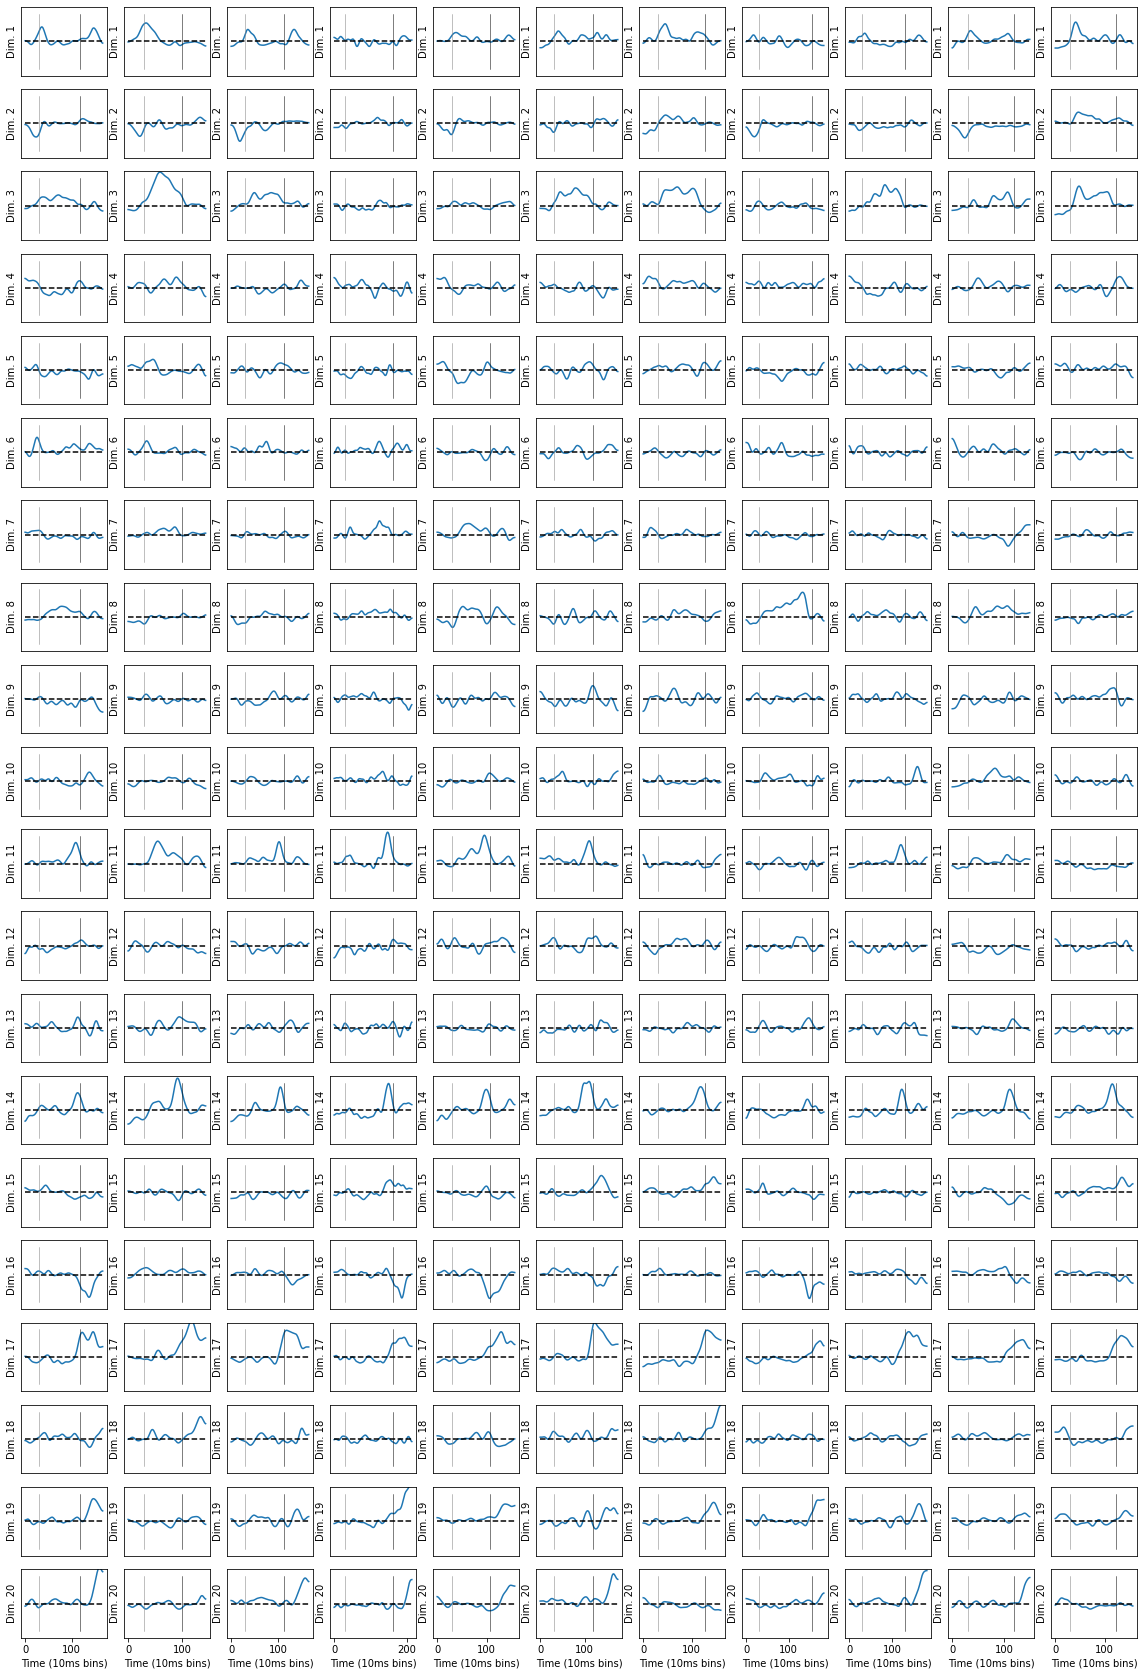

In [100]:
#Get indices of each trial
# T=interp_array.shape[2] #Length of time per condition



tr_lengths_cum=np.hstack([0, np.cumsum(tr_lengths)])

trs=[0,1,2,3,4,5,6,7,8,9,10]

t_idxs=[np.arange(tr_lengths_cum[tr],tr_lengths_cum[tr+1]) for tr in trs]




fig,ax=plt.subplots(R_est,len(trs),figsize=(20,30))
for i in range(R_est):
    for k,j in enumerate(trs):
        
        tgt_idx=30        
        move_idx=int(move_time_rel[0,j]/10)+30
        T=tr_lengths[j]

        ax[i,k].plot(ssa_latent[:,order[i]][t_idxs[j]],linewidth=1.5)
        
        ax[i,k].plot([tgt_idx,tgt_idx],[-4,4],'gray',linewidth=.5)
        ax[i,k].plot([move_idx,move_idx],[-4,4],'k',linewidth=.5)
        ax[i,k].plot([0,T],[0,0],'k--')

#         ax[i,k].set_xlim([0,T+1])
        ax[i,k].set_ylim([-5, 5])

        if i<R_est-1:
            ax[i,k].set_xticks([])
        else:
            ax[i,k].set_xlabel('Time (10ms bins)')
            
        ax[i,k].set_yticks([])
        ax[i,k].set_ylabel('Dim. '+str(i+1))

#     ax[0].set_title('SCA')